In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score
from Amin_utility import my_SmilesTokenizer, model_train_cross_validation
from sklearn.model_selection import train_test_split


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
file_path = '/content/BBBP.csv'
df = pd.read_csv(file_path)


# SMILES Notation Overview

SMILES (Simplified Molecular Input Line Entry System) notation uses a variety of symbols and conventions to represent chemical structures. Here's an overview of the key notations in a SMILES string:

1. **Atoms**: Represented by their elemental symbols (e.g., C for carbon, O for oxygen).

2. **Bonds**:
   - Single bonds are typically implicit and not explicitly mentioned.
   - Double bonds are represented by '='.
   - Triple bonds are represented by '#'.
   - Aromatic bonds are often indicated by lowercase letters (e.g., 'c' for an aromatic carbon).

3. **Branching**:
   - Parentheses '()' are used to indicate branching or groups of atoms. The contents inside the parentheses are treated as a single unit.
   - Backslash "\" is used to show branching points, indicating the attachment of a branch.

4. **Ring Closure**:
   - Numbers are used to represent ring closures. A number in a SMILES string indicates that the atoms with the same number are part of the same ring. The ring is closed by repeating the same number.

5. **Isotopes**:
   - Percent "%" is used to represent atomic isotopes. It is followed by the atomic mass number to denote a specific isotope of an element.

6. **Chirality**:
   - '@' and '/' or '\' are used to denote chirality around a stereocenter. '@' indicates a tetrahedral stereocenter, and '/' or '\' indicates the direction of rotation.

7. **Aromaticity**:
   - Aromatic rings are often represented by lowercase letters (e.g., 'c' for an aromatic carbon). Aromatic rings can also be explicitly denoted using the aromatic bond ('1', '2', '3', ...) notation.

8. **Hydrogens**:
   - Hydrogens are usually implicit, but they can be represented explicitly when necessary.

These notations allow chemists to represent and share chemical structures in a standardized and concise format, aiding in computational chemistry, chemical databases, and chemical informatics.



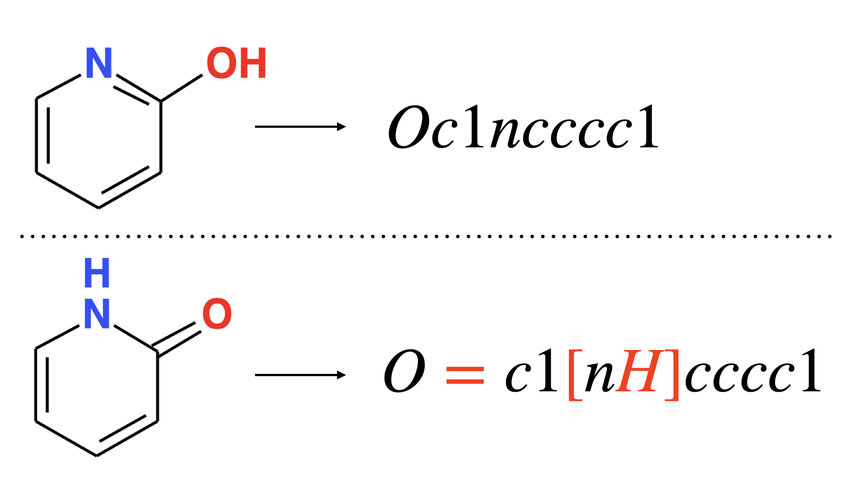

# Data visualization

In [40]:
tokenizer = my_SmilesTokenizer()
df['smiles_length'] = df['smiles'].apply(lambda x: len(x))
df['tokens'] = df['smiles'].apply(lambda x: tokenizer.tokenize(x))
df['atoms'] = df['tokens'].apply(tokenizer.get_atoms)

# Calculate lengths based on atoms
df['length'] = df['atoms'].apply(len)

# Maximum and Minimun length of SMILES string
max_length_ = df['smiles_length'].max()
min_length = df['smiles_length'].min()
print('Maximum length of SMILES string: ', max_length_)
print('Minimum length of SMILES string: ', min_length)

print('Number of SMILES string: ', len(df))



Maximum length of SMILES string:  400
Minimum length of SMILES string:  3
Number of SMILES string:  2050


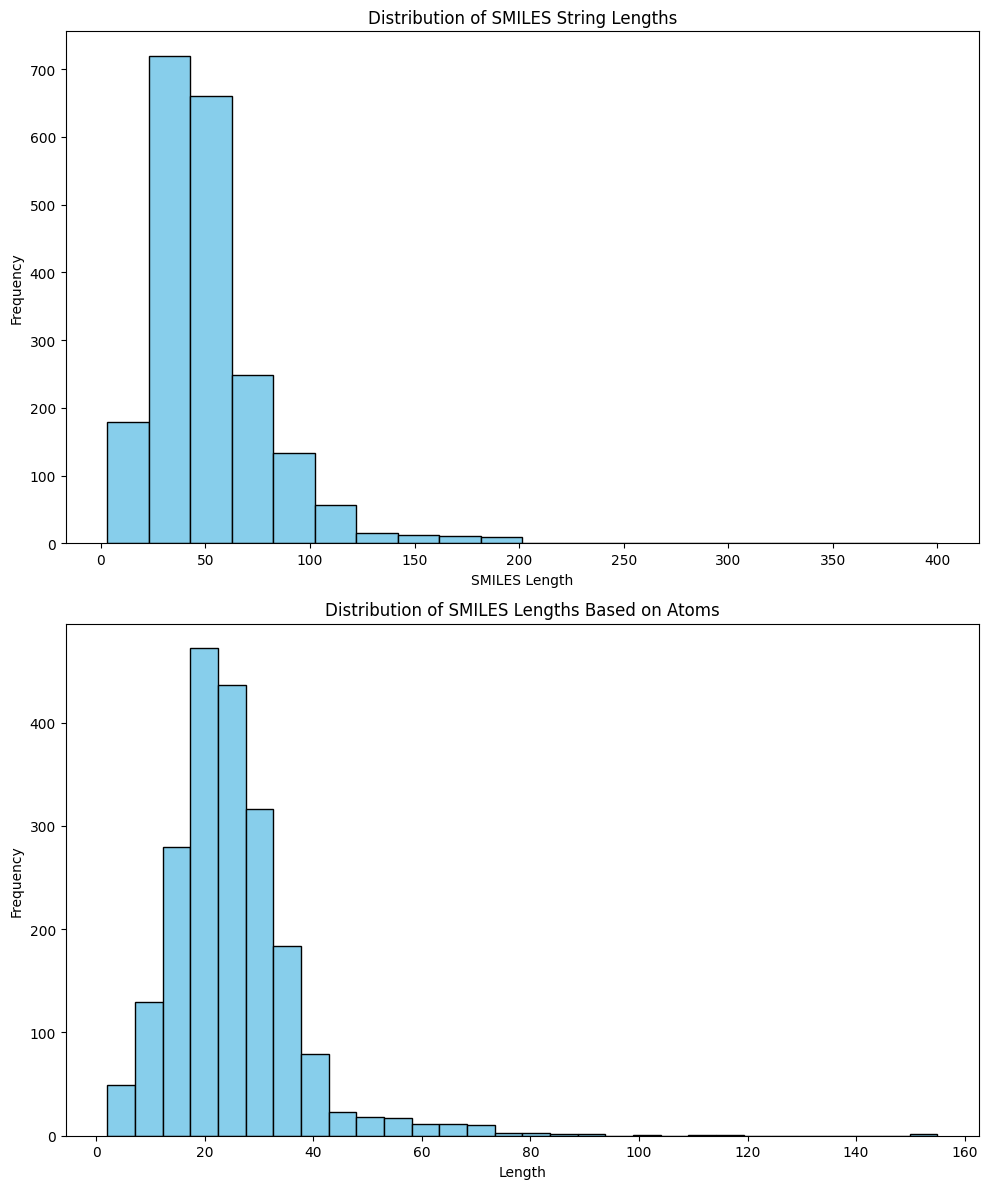

In [41]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Plot the distribution of SMILES lengths
axs[0].hist(df['smiles_length'], bins=20, color='skyblue', edgecolor='black')
axs[0].set_title('Distribution of SMILES String Lengths')
axs[0].set_xlabel('SMILES Length')
axs[0].set_ylabel('Frequency')

# Plot histogram of lengths based on atoms
axs[1].hist(df['length'], bins=30, color='skyblue', edgecolor='black')
axs[1].set_title('Distribution of SMILES Lengths Based on Atoms')
axs[1].set_xlabel('Length')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


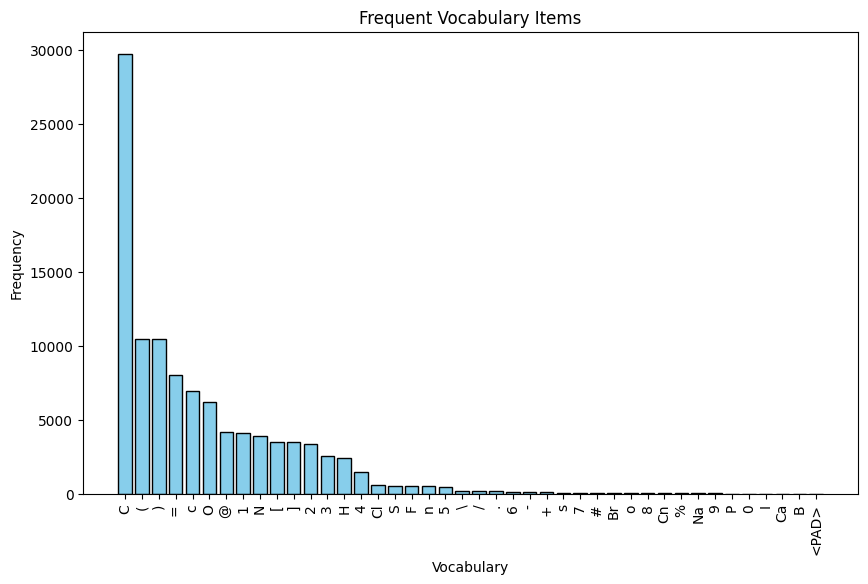

In [42]:
# Get vocabulary and its frequency
vocabulary = tokenizer.get_vocabulary()
frequency = {vocab: sum(df['tokens'].apply(lambda tokens: tokens.count(vocab))) for vocab in vocabulary}
frequency_df = pd.DataFrame(list(frequency.items()), columns=['Vocabulary', 'Frequency'])
top_frequency_df = frequency_df.sort_values('Frequency', ascending=False)

# Plot bar chart of vocabulary frequency
plt.figure(figsize=(10, 6))
plt.bar(top_frequency_df['Vocabulary'], top_frequency_df['Frequency'], color='skyblue', edgecolor='black')
plt.title('Frequent Vocabulary Items')
plt.xlabel('Vocabulary')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

In [43]:
vocab_size = len(tokenizer.get_vocabulary())
print('Vocabulary size: ', vocab_size)

max_length = 100
df['embedded'] = df['tokens'].apply(lambda x: tokenizer.embedded_smiles(x,max_length=max_length))


Vocabulary size:  42


# Dataset

In [44]:
class SMILES_Dataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        encoded = self.df.iloc[idx]['embedded']
        label = self.df.iloc[idx]['p_np']
        return encoded, label

In [45]:
train_ratio = 0.8
df_train, df_test = train_test_split(df, test_size=1-train_ratio)

print(f"Length of Training Set: {len(df_train)}")
print(f"Length of Test Set: {len(df_test)}")

Length of Training Set: 1640
Length of Test Set: 410


In [46]:
train_dataset = SMILES_Dataset(df_train)
test_dataset = SMILES_Dataset(df_test)


In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Train Models

## FC model

In [48]:
# FC model
class FC(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(FC, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(x.size(0), -1).float()
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out


In [66]:
model_fc = FC(input_size=max_length*vocab_size , hidden_size=200).to(device)
optimizer_fc = optim.Adam(model_fc.parameters(), lr=5e-4)
criterion_fc = nn.BCELoss()


 
 Fold: 1 ########################################################################################################################


100%|██████████| 11/11 [00:00<00:00, 36.64it/s]


Epoch 1/20, Train Loss: 0.5597, Train accuracy:75.69 Validation Loss: 0.4530, Validation accuracy:79.88
Saved best model


100%|██████████| 11/11 [00:00<00:00, 37.33it/s]


Saved best model


100%|██████████| 11/11 [00:00<00:00, 40.26it/s]


Saved best model


100%|██████████| 11/11 [00:00<00:00, 40.68it/s]


Saved best model


100%|██████████| 11/11 [00:00<00:00, 36.54it/s]


Epoch 6/20, Train Loss: 0.2356, Train accuracy:90.17 Validation Loss: 0.3293, Validation accuracy:87.80
Saved best model


100%|██████████| 11/11 [00:00<00:00, 28.33it/s]


Epoch 11/20, Train Loss: 0.1270, Train accuracy:96.42 Validation Loss: 0.3411, Validation accuracy:87.80


100%|██████████| 11/11 [00:00<00:00, 39.47it/s]


Epoch 16/20, Train Loss: 0.0820, Train accuracy:98.25 Validation Loss: 0.3728, Validation accuracy:86.89


100%|██████████| 11/11 [00:00<00:00, 40.57it/s]


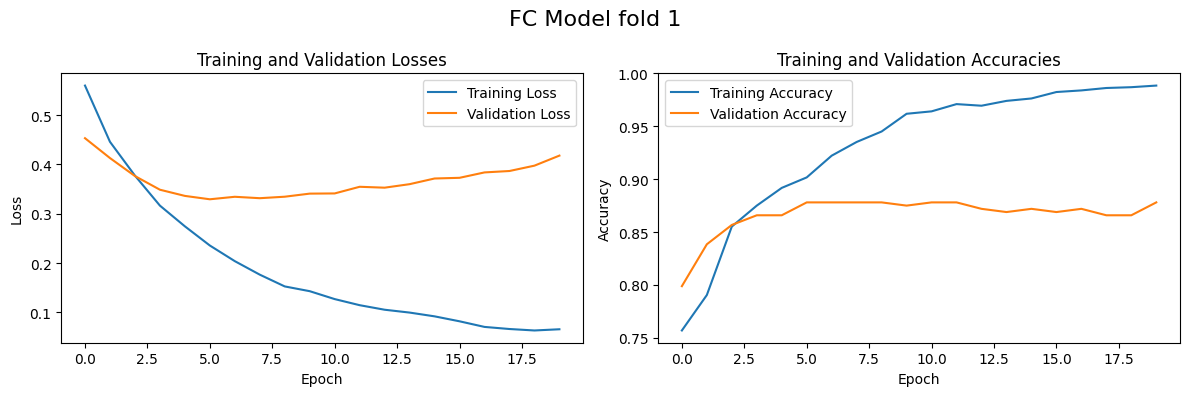


 
 Fold: 2 ########################################################################################################################


100%|██████████| 11/11 [00:00<00:00, 37.53it/s]


Epoch 1/20, Train Loss: 0.1393, Train accuracy:95.81 Validation Loss: 0.0451, Validation accuracy:99.39
Saved best model


100%|██████████| 11/11 [00:00<00:00, 29.62it/s]


Saved best model


100%|██████████| 11/11 [00:00<00:00, 39.89it/s]


Epoch 6/20, Train Loss: 0.0677, Train accuracy:98.40 Validation Loss: 0.0618, Validation accuracy:97.56


100%|██████████| 11/11 [00:00<00:00, 39.38it/s]


Epoch 11/20, Train Loss: 0.0423, Train accuracy:99.01 Validation Loss: 0.0728, Validation accuracy:95.73


100%|██████████| 11/11 [00:00<00:00, 39.10it/s]


Epoch 16/20, Train Loss: 0.0309, Train accuracy:99.54 Validation Loss: 0.0899, Validation accuracy:95.43


100%|██████████| 11/11 [00:00<00:00, 25.16it/s]


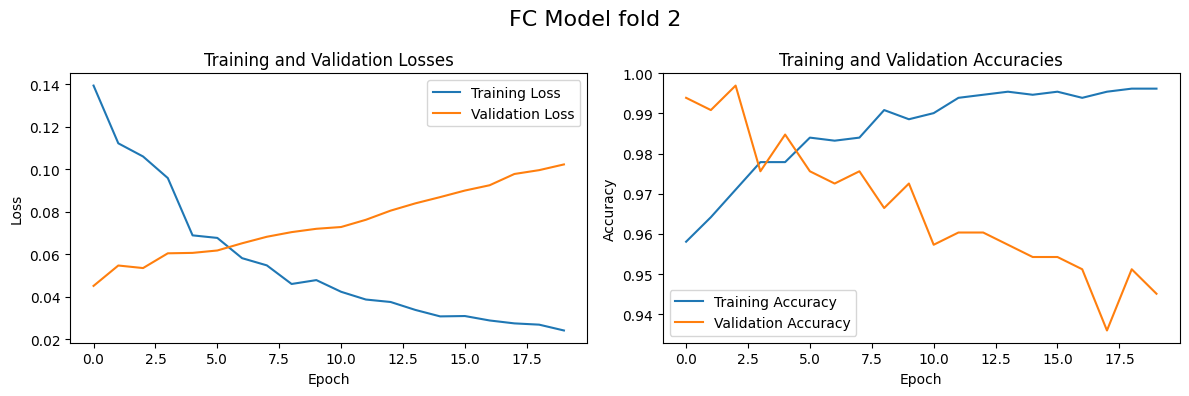


 
 Fold: 3 ########################################################################################################################


100%|██████████| 11/11 [00:00<00:00, 22.59it/s]


Epoch 1/20, Train Loss: 0.0457, Train accuracy:98.48 Validation Loss: 0.0211, Validation accuracy:99.39


100%|██████████| 11/11 [00:00<00:00, 39.34it/s]


Epoch 6/20, Train Loss: 0.0211, Train accuracy:99.62 Validation Loss: 0.0302, Validation accuracy:99.09


100%|██████████| 11/11 [00:00<00:00, 39.64it/s]


Epoch 11/20, Train Loss: 0.0149, Train accuracy:99.85 Validation Loss: 0.0345, Validation accuracy:99.09


100%|██████████| 11/11 [00:00<00:00, 39.60it/s]


Epoch 16/20, Train Loss: 0.0117, Train accuracy:99.92 Validation Loss: 0.0423, Validation accuracy:99.09


100%|██████████| 11/11 [00:00<00:00, 38.83it/s]


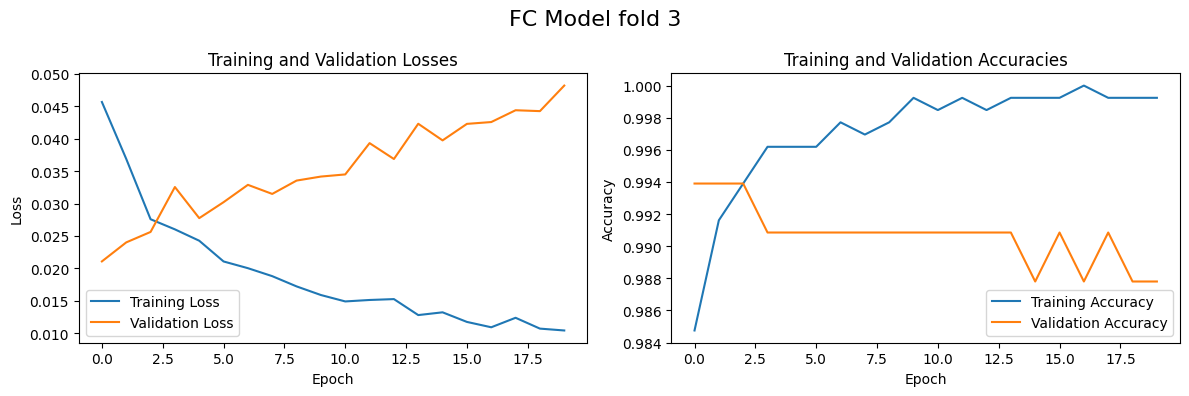


 
 Fold: 4 ########################################################################################################################


100%|██████████| 11/11 [00:00<00:00, 37.54it/s]


Epoch 1/20, Train Loss: 0.0202, Train accuracy:99.47 Validation Loss: 0.0088, Validation accuracy:100.00
Saved best model


100%|██████████| 11/11 [00:00<00:00, 39.23it/s]


Epoch 6/20, Train Loss: 0.0111, Train accuracy:99.85 Validation Loss: 0.0119, Validation accuracy:100.00


100%|██████████| 11/11 [00:00<00:00, 25.33it/s]


Epoch 11/20, Train Loss: 0.0091, Train accuracy:99.92 Validation Loss: 0.0127, Validation accuracy:100.00


100%|██████████| 11/11 [00:00<00:00, 40.29it/s]


Epoch 16/20, Train Loss: 0.0067, Train accuracy:100.00 Validation Loss: 0.0139, Validation accuracy:100.00


100%|██████████| 11/11 [00:00<00:00, 38.88it/s]


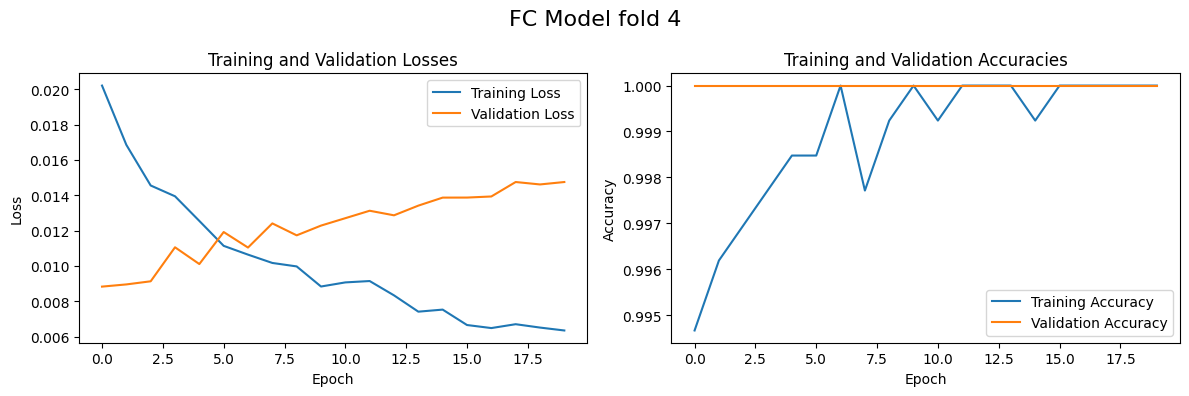


 
 Fold: 5 ########################################################################################################################


100%|██████████| 11/11 [00:00<00:00, 38.28it/s]


Epoch 1/20, Train Loss: 0.0083, Train accuracy:100.00 Validation Loss: 0.0047, Validation accuracy:100.00


100%|██████████| 11/11 [00:00<00:00, 38.76it/s]


Epoch 6/20, Train Loss: 0.0061, Train accuracy:99.92 Validation Loss: 0.0056, Validation accuracy:100.00


100%|██████████| 11/11 [00:00<00:00, 40.60it/s]


Epoch 11/20, Train Loss: 0.0051, Train accuracy:100.00 Validation Loss: 0.0061, Validation accuracy:100.00


100%|██████████| 11/11 [00:00<00:00, 38.49it/s]


Epoch 16/20, Train Loss: 0.0041, Train accuracy:100.00 Validation Loss: 0.0065, Validation accuracy:100.00


100%|██████████| 11/11 [00:00<00:00, 25.83it/s]


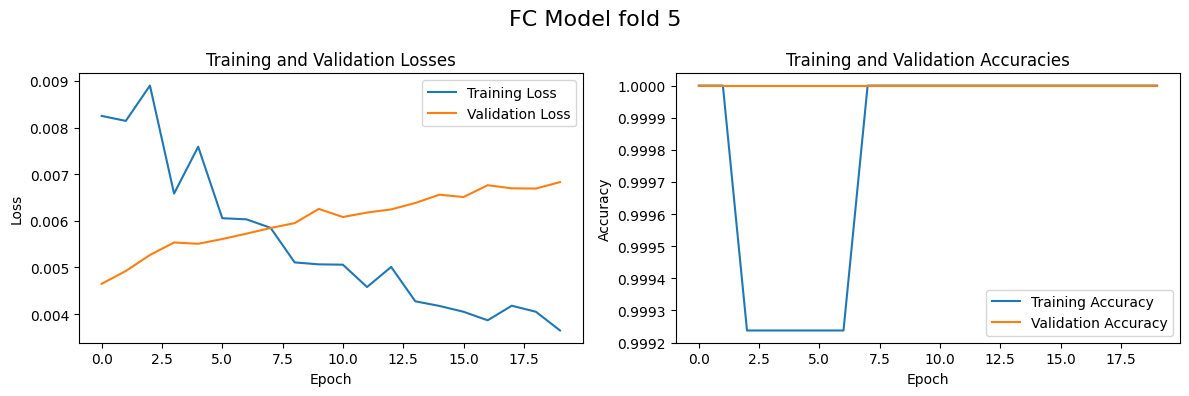

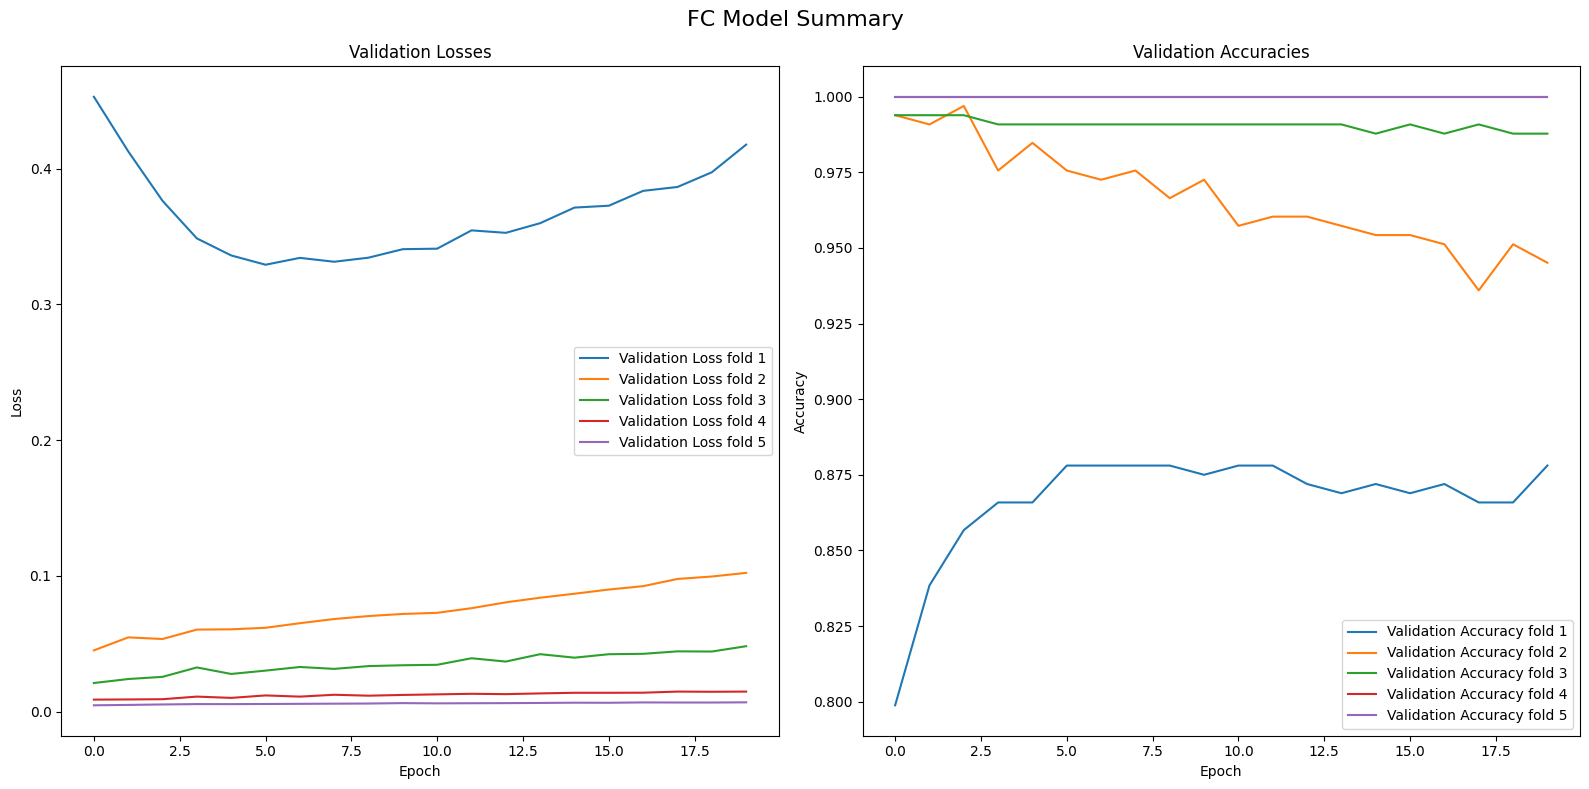


 
 Test Loss: 0.7237, Test accuracy:83.66


In [67]:
my = model_train_cross_validation(model=model_fc, Name="FC", n_splits=5, train_dataset=train_dataset, test_dataset=test_dataset, batch_size=128,
                                 optimizer=optimizer_fc, criterion=criterion_fc, num_epochs=20, device=device,Print_details=True)

my.train()
my.test()


## LSTM

In [63]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate=0.3):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=False, dropout=dropout_rate)
        self.batchnorm = nn.BatchNorm1d(hidden_size)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.batchnorm(out)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.batchnorm1(out)
        out = self.fc2(out)
        out = self.sigmoid(out)

        return out

In [64]:
model_LSTM = LSTM(input_size=vocab_size , hidden_size=200, num_layers=4).to(device)
optimizer_LSTM = optim.Adam(model_LSTM.parameters(), lr=5e-4)
criterion_LSTM= nn.BCELoss()


 
 Fold: 1 ########################################################################################################################


100%|██████████| 11/11 [00:00<00:00, 14.44it/s]


Epoch 1/20, Train Loss: 0.7057, Train accuracy:54.12 Validation Loss: 0.6644, Validation accuracy:78.66
Saved best model


100%|██████████| 11/11 [00:00<00:00, 16.54it/s]


Saved best model


100%|██████████| 11/11 [00:00<00:00, 16.47it/s]


Saved best model


100%|██████████| 11/11 [00:00<00:00, 16.99it/s]


Epoch 6/20, Train Loss: 0.4943, Train accuracy:79.19 Validation Loss: 0.6308, Validation accuracy:73.48


100%|██████████| 11/11 [00:00<00:00, 14.19it/s]


Saved best model


100%|██████████| 11/11 [00:00<00:00, 13.97it/s]


Saved best model


100%|██████████| 11/11 [00:00<00:00, 16.66it/s]


Saved best model


100%|██████████| 11/11 [00:00<00:00, 16.83it/s]


Epoch 11/20, Train Loss: 0.4125, Train accuracy:84.91 Validation Loss: 0.3599, Validation accuracy:86.28


100%|██████████| 11/11 [00:00<00:00, 17.13it/s]


Epoch 16/20, Train Loss: 0.3613, Train accuracy:87.42 Validation Loss: 0.3217, Validation accuracy:85.67


100%|██████████| 11/11 [00:00<00:00, 16.83it/s]


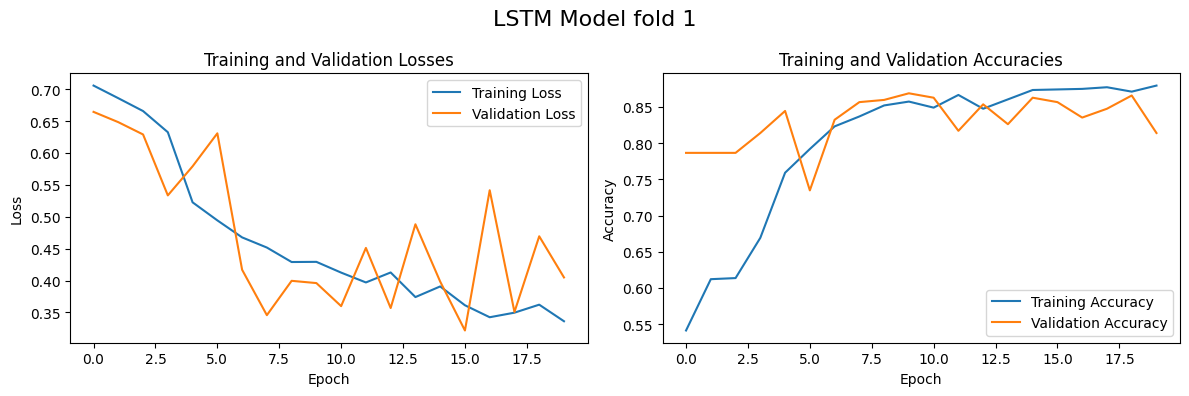


 
 Fold: 2 ########################################################################################################################


100%|██████████| 11/11 [00:00<00:00, 16.42it/s]


Epoch 1/20, Train Loss: 0.3618, Train accuracy:88.19 Validation Loss: 0.3732, Validation accuracy:84.45


100%|██████████| 11/11 [00:00<00:00, 16.43it/s]


Epoch 6/20, Train Loss: 0.3236, Train accuracy:87.88 Validation Loss: 0.3381, Validation accuracy:84.15


100%|██████████| 11/11 [00:00<00:00, 16.22it/s]


Epoch 11/20, Train Loss: 0.3056, Train accuracy:87.65 Validation Loss: 0.4288, Validation accuracy:80.79


100%|██████████| 11/11 [00:00<00:00, 14.69it/s]


Epoch 16/20, Train Loss: 0.2972, Train accuracy:87.73 Validation Loss: 0.3609, Validation accuracy:85.67


100%|██████████| 11/11 [00:00<00:00, 16.59it/s]


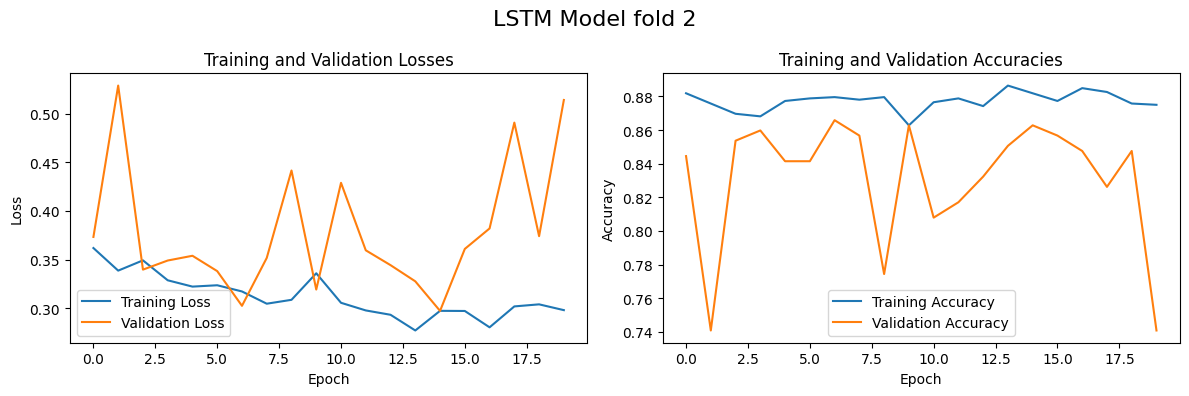


 
 Fold: 3 ########################################################################################################################


100%|██████████| 11/11 [00:00<00:00, 15.68it/s]


Epoch 1/20, Train Loss: 0.3101, Train accuracy:87.58 Validation Loss: 0.4431, Validation accuracy:82.01


100%|██████████| 11/11 [00:00<00:00, 16.34it/s]


Saved best model


100%|██████████| 11/11 [00:00<00:00, 16.58it/s]


Saved best model


100%|██████████| 11/11 [00:00<00:00, 16.45it/s]


Epoch 6/20, Train Loss: 0.2802, Train accuracy:87.35 Validation Loss: 0.3285, Validation accuracy:85.37


100%|██████████| 11/11 [00:00<00:00, 13.20it/s]


Epoch 11/20, Train Loss: 0.2786, Train accuracy:88.03 Validation Loss: 0.5675, Validation accuracy:81.40


100%|██████████| 11/11 [00:00<00:00, 16.17it/s]


Epoch 16/20, Train Loss: 0.2669, Train accuracy:88.19 Validation Loss: 0.3594, Validation accuracy:84.76


100%|██████████| 11/11 [00:00<00:00, 16.48it/s]


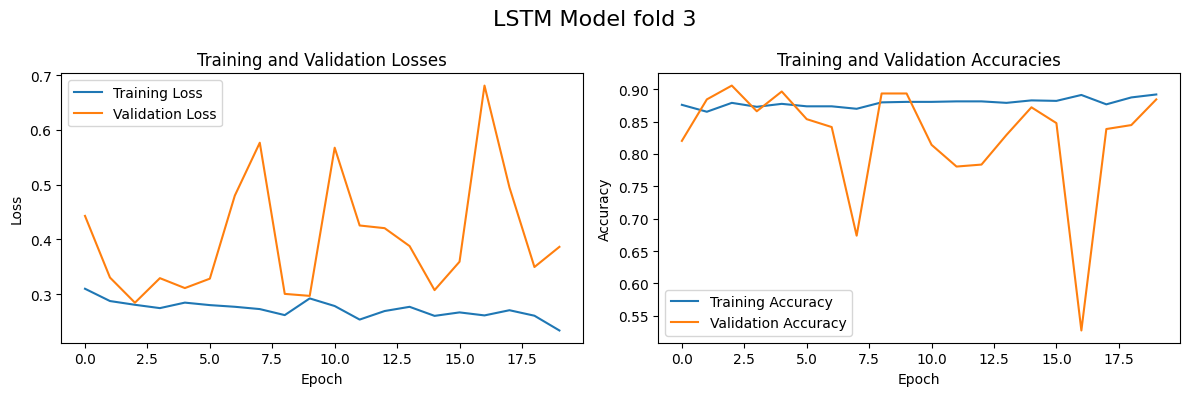


 
 Fold: 4 ########################################################################################################################


100%|██████████| 11/11 [00:00<00:00, 16.22it/s]


Epoch 1/20, Train Loss: 0.2882, Train accuracy:87.80 Validation Loss: 0.4097, Validation accuracy:88.41


100%|██████████| 11/11 [00:00<00:00, 13.30it/s]


Epoch 6/20, Train Loss: 0.2451, Train accuracy:90.02 Validation Loss: 0.2449, Validation accuracy:88.41


100%|██████████| 11/11 [00:00<00:00, 15.96it/s]


Epoch 11/20, Train Loss: 0.2502, Train accuracy:88.87 Validation Loss: 0.6364, Validation accuracy:83.23


100%|██████████| 11/11 [00:00<00:00, 16.01it/s]


Epoch 16/20, Train Loss: 0.2240, Train accuracy:90.32 Validation Loss: 0.5504, Validation accuracy:82.01


100%|██████████| 11/11 [00:00<00:00, 12.83it/s]


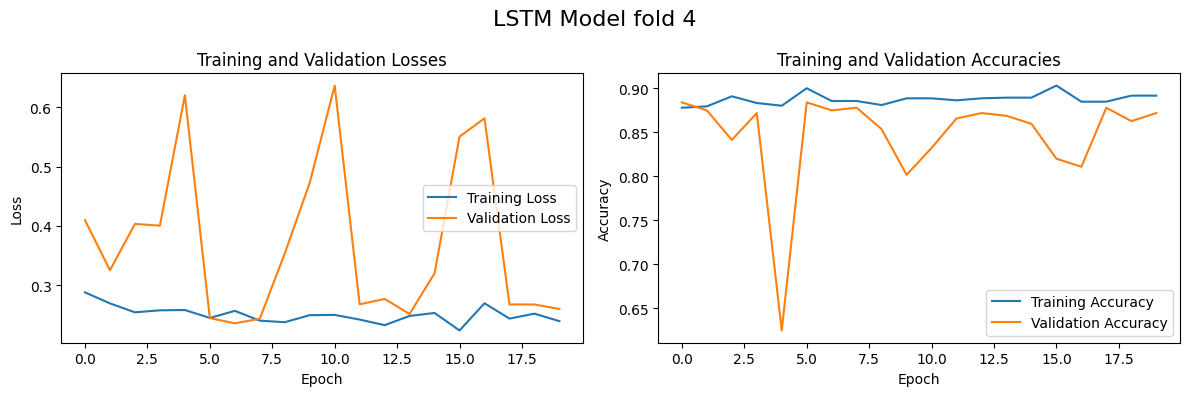


 
 Fold: 5 ########################################################################################################################


100%|██████████| 11/11 [00:00<00:00, 16.21it/s]


Epoch 1/20, Train Loss: 0.2513, Train accuracy:89.02 Validation Loss: 0.2103, Validation accuracy:93.29
Saved best model


100%|██████████| 11/11 [00:00<00:00, 16.37it/s]


Epoch 6/20, Train Loss: 0.2475, Train accuracy:88.72 Validation Loss: 0.2918, Validation accuracy:92.99


100%|██████████| 11/11 [00:00<00:00, 16.52it/s]


Epoch 11/20, Train Loss: 0.2311, Train accuracy:89.25 Validation Loss: 0.1790, Validation accuracy:92.38


100%|██████████| 11/11 [00:00<00:00, 16.61it/s]


Epoch 16/20, Train Loss: 0.2461, Train accuracy:88.49 Validation Loss: 0.4084, Validation accuracy:91.16


100%|██████████| 11/11 [00:00<00:00, 16.03it/s]


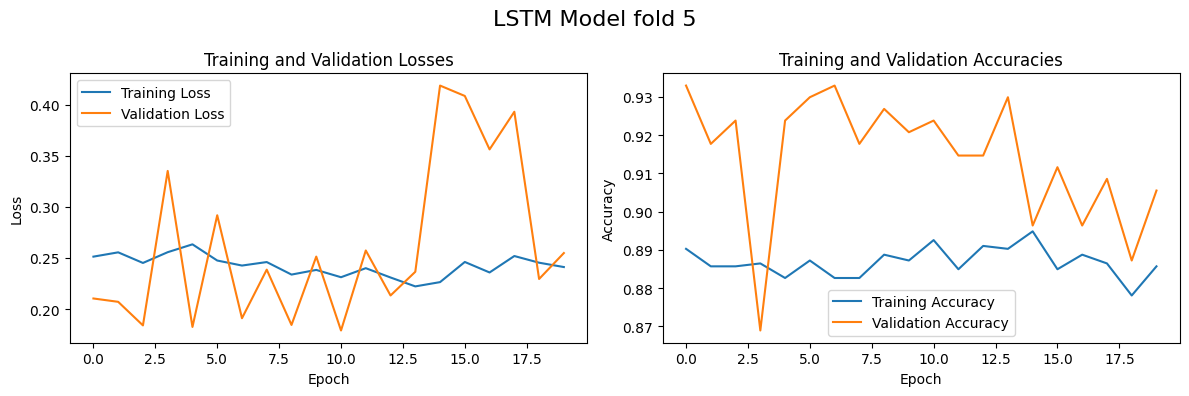

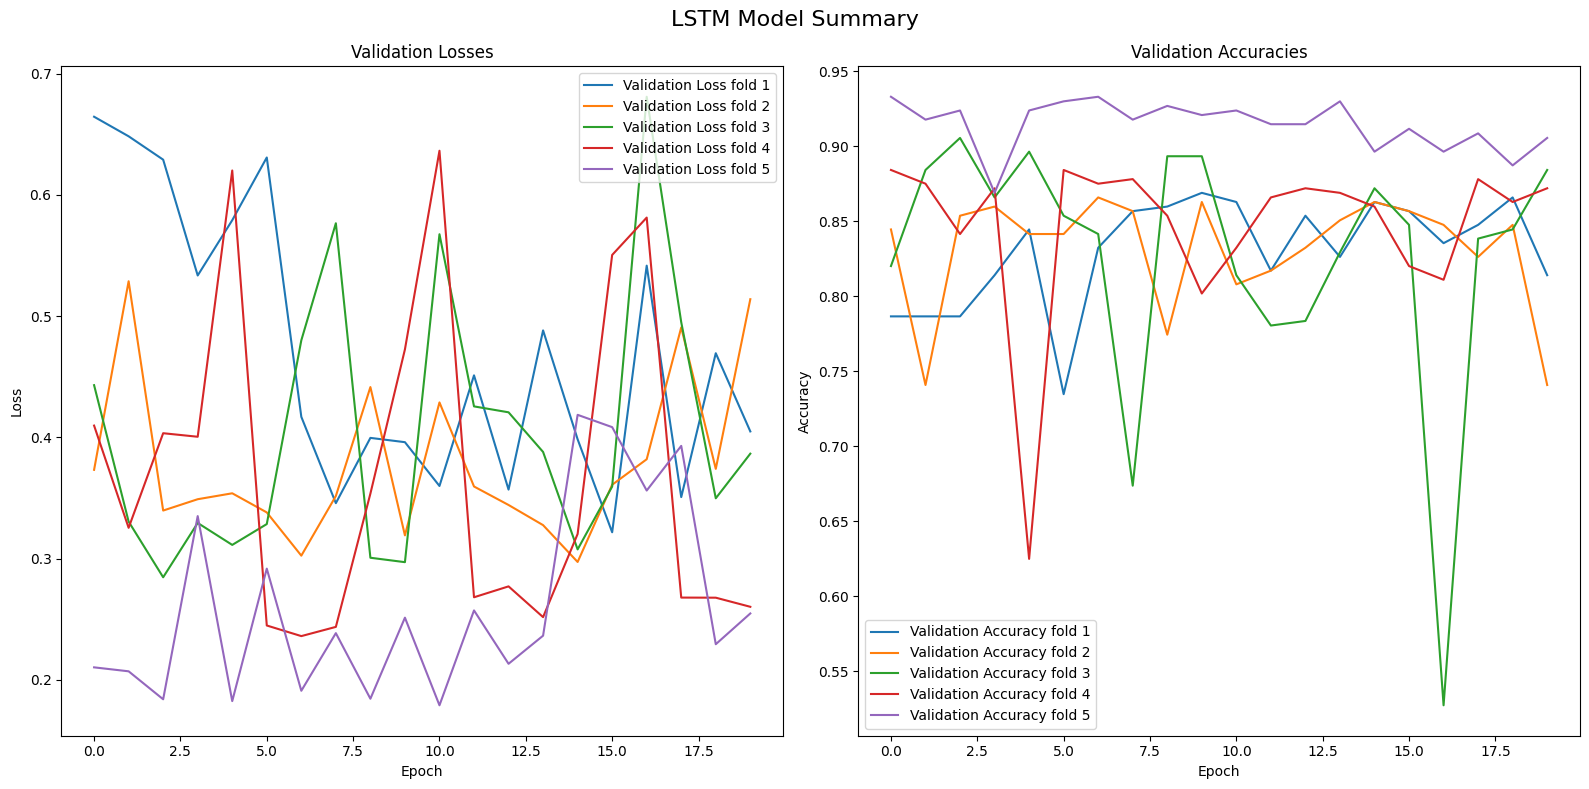


 
 Test Loss: 0.4193, Test accuracy:87.32


In [65]:
my = model_train_cross_validation(model=model_LSTM, Name="LSTM", n_splits=5, train_dataset=train_dataset, test_dataset=test_dataset, batch_size=128,
                                 optimizer=optimizer_LSTM, criterion=criterion_LSTM, num_epochs=20, device=device,Print_details=True)

my.train()
my.test()


## BiLSTM

In [54]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate=0.3):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)
        self.batchnorm = nn.BatchNorm1d(hidden_size*2)
        self.fc1 = nn.Linear(hidden_size*2, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.randn(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.randn(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.bilstm(x.float(), (h0, c0))
        out = torch.cat((out[:, -1, :self.hidden_size], out[:, 0, self.hidden_size:]), dim=1)
        out = self.batchnorm(out)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.batchnorm2(out)
        out = self.fc2(out)
        out = self.sigmoid(out)

        return out

In [55]:
model_BiLSTM = BiLSTM(input_size=vocab_size , hidden_size=200, num_layers=4).to(device)
optimizer_BiLSTM = optim.Adam(model_BiLSTM.parameters(), lr=5e-4)
criterion_BiLSTM = nn.BCELoss()


 
 Fold: 1 ########################################################################################################################


100%|██████████| 11/11 [00:01<00:00,  7.30it/s]


Epoch 1/20, Train Loss: 0.7231, Train accuracy:50.30 Validation Loss: 0.6873, Validation accuracy:70.73
Saved best model


100%|██████████| 11/11 [00:01<00:00,  7.47it/s]


Epoch 6/20, Train Loss: 0.6680, Train accuracy:58.23 Validation Loss: 0.6259, Validation accuracy:68.60


100%|██████████| 11/11 [00:01<00:00,  7.46it/s]


Saved best model


100%|██████████| 11/11 [00:01<00:00,  7.48it/s]


Saved best model


100%|██████████| 11/11 [00:01<00:00,  6.94it/s]


Saved best model


100%|██████████| 11/11 [00:01<00:00,  7.12it/s]


Saved best model


100%|██████████| 11/11 [00:01<00:00,  7.06it/s]


Epoch 11/20, Train Loss: 0.4546, Train accuracy:83.08 Validation Loss: 0.5721, Validation accuracy:76.22


100%|██████████| 11/11 [00:01<00:00,  7.49it/s]


Saved best model


100%|██████████| 11/11 [00:01<00:00,  7.17it/s]


Saved best model


100%|██████████| 11/11 [00:01<00:00,  6.88it/s]


Epoch 16/20, Train Loss: 0.3958, Train accuracy:86.59 Validation Loss: 0.3114, Validation accuracy:89.33


100%|██████████| 11/11 [00:01<00:00,  7.42it/s]


Saved best model


100%|██████████| 11/11 [00:01<00:00,  7.33it/s]


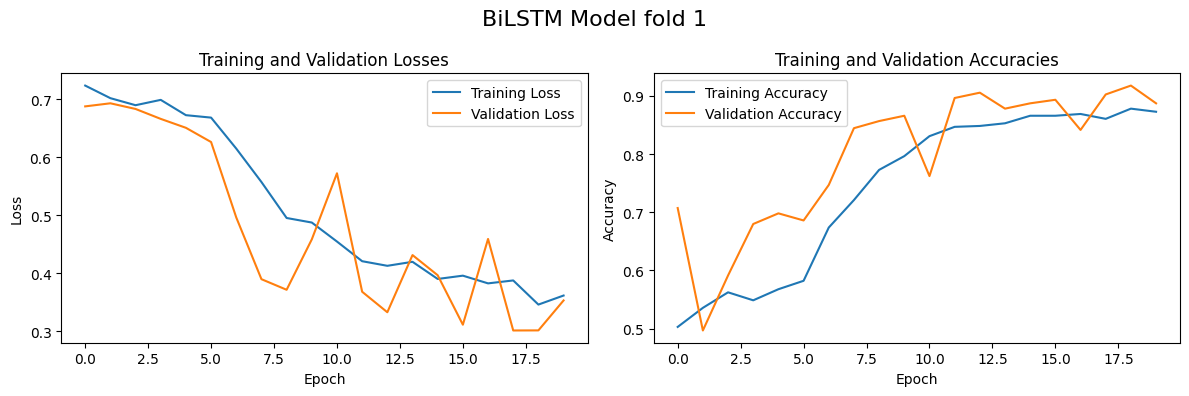


 
 Fold: 2 ########################################################################################################################


100%|██████████| 11/11 [00:01<00:00,  7.43it/s]


Epoch 1/20, Train Loss: 0.3614, Train accuracy:86.97 Validation Loss: 0.3567, Validation accuracy:83.84


100%|██████████| 11/11 [00:01<00:00,  6.91it/s]


Epoch 6/20, Train Loss: 0.4054, Train accuracy:82.93 Validation Loss: 0.3494, Validation accuracy:85.67


100%|██████████| 11/11 [00:01<00:00,  7.09it/s]


Epoch 11/20, Train Loss: 0.3073, Train accuracy:88.19 Validation Loss: 0.3454, Validation accuracy:87.80


100%|██████████| 11/11 [00:02<00:00,  5.20it/s]


Epoch 16/20, Train Loss: 0.2869, Train accuracy:89.02 Validation Loss: 0.3871, Validation accuracy:87.20


100%|██████████| 11/11 [00:01<00:00,  7.66it/s]


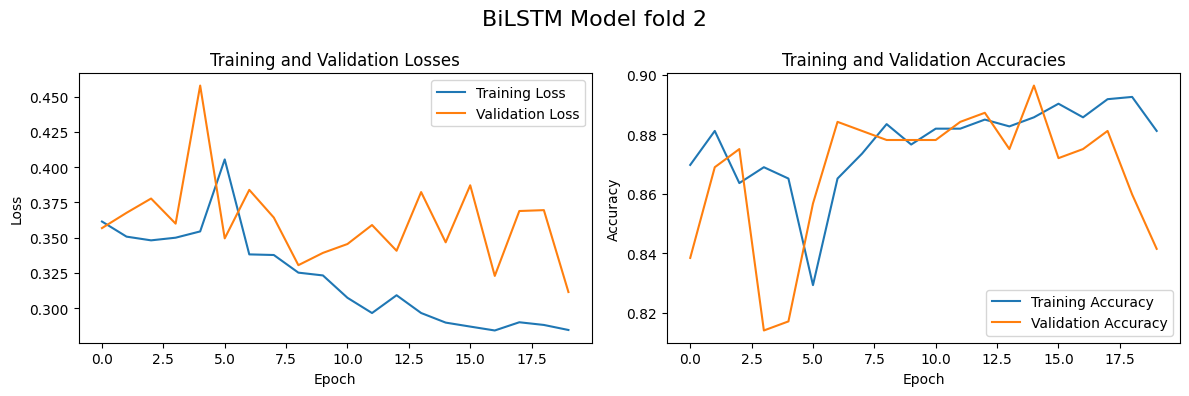


 
 Fold: 3 ########################################################################################################################


100%|██████████| 11/11 [00:01<00:00,  7.51it/s]


Epoch 1/20, Train Loss: 0.2943, Train accuracy:88.49 Validation Loss: 0.3498, Validation accuracy:85.37


100%|██████████| 11/11 [00:01<00:00,  7.49it/s]


Epoch 6/20, Train Loss: 0.2590, Train accuracy:89.86 Validation Loss: 0.2555, Validation accuracy:88.41


100%|██████████| 11/11 [00:01<00:00,  6.74it/s]


Epoch 11/20, Train Loss: 0.2573, Train accuracy:89.94 Validation Loss: 0.2746, Validation accuracy:89.63


100%|██████████| 11/11 [00:01<00:00,  7.48it/s]


Epoch 16/20, Train Loss: 0.2277, Train accuracy:90.24 Validation Loss: 0.2613, Validation accuracy:88.72


100%|██████████| 11/11 [00:01<00:00,  7.43it/s]


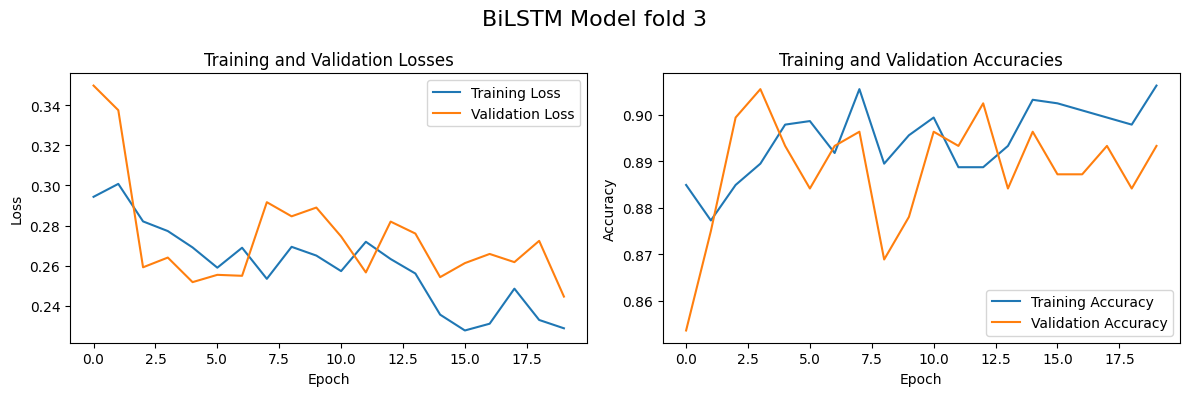


 
 Fold: 4 ########################################################################################################################


100%|██████████| 11/11 [00:01<00:00,  7.43it/s]


Epoch 1/20, Train Loss: 0.2333, Train accuracy:90.62 Validation Loss: 0.2182, Validation accuracy:90.55


100%|██████████| 11/11 [00:01<00:00,  6.97it/s]


Epoch 6/20, Train Loss: 0.2430, Train accuracy:89.56 Validation Loss: 0.2641, Validation accuracy:87.50


100%|██████████| 11/11 [00:01<00:00,  7.53it/s]


Epoch 11/20, Train Loss: 0.2200, Train accuracy:90.85 Validation Loss: 0.2569, Validation accuracy:86.59


100%|██████████| 11/11 [00:01<00:00,  7.47it/s]


Epoch 16/20, Train Loss: 0.2377, Train accuracy:89.56 Validation Loss: 0.2436, Validation accuracy:89.63


100%|██████████| 11/11 [00:01<00:00,  7.06it/s]


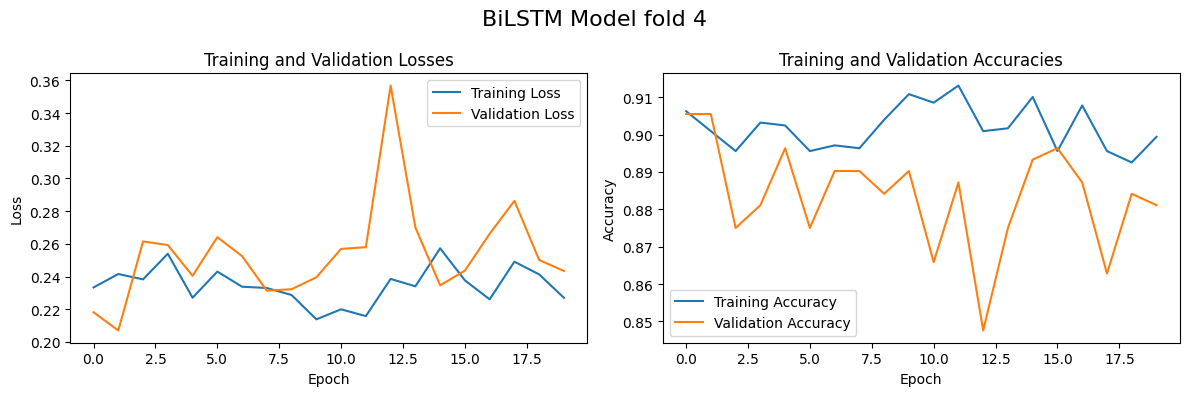


 
 Fold: 5 ########################################################################################################################


100%|██████████| 11/11 [00:01<00:00,  7.40it/s]


Epoch 1/20, Train Loss: 0.2130, Train accuracy:91.69 Validation Loss: 0.2708, Validation accuracy:89.33


100%|██████████| 11/11 [00:01<00:00,  6.85it/s]


Epoch 6/20, Train Loss: 0.2290, Train accuracy:90.93 Validation Loss: 0.2618, Validation accuracy:88.72


100%|██████████| 11/11 [00:01<00:00,  6.96it/s]


Epoch 11/20, Train Loss: 0.2625, Train accuracy:87.96 Validation Loss: 0.2421, Validation accuracy:89.94


100%|██████████| 11/11 [00:01<00:00,  6.58it/s]


Epoch 16/20, Train Loss: 0.1935, Train accuracy:92.07 Validation Loss: 0.2673, Validation accuracy:89.02


100%|██████████| 11/11 [00:01<00:00,  7.50it/s]


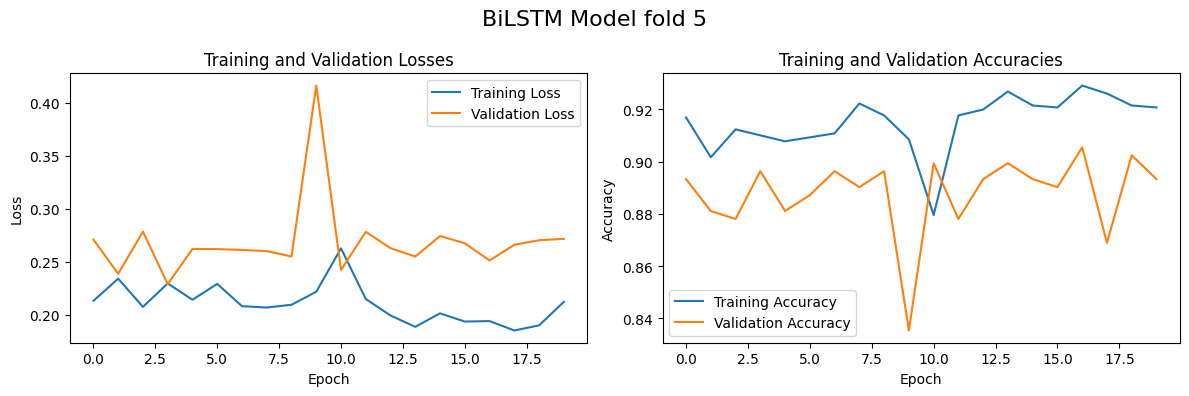

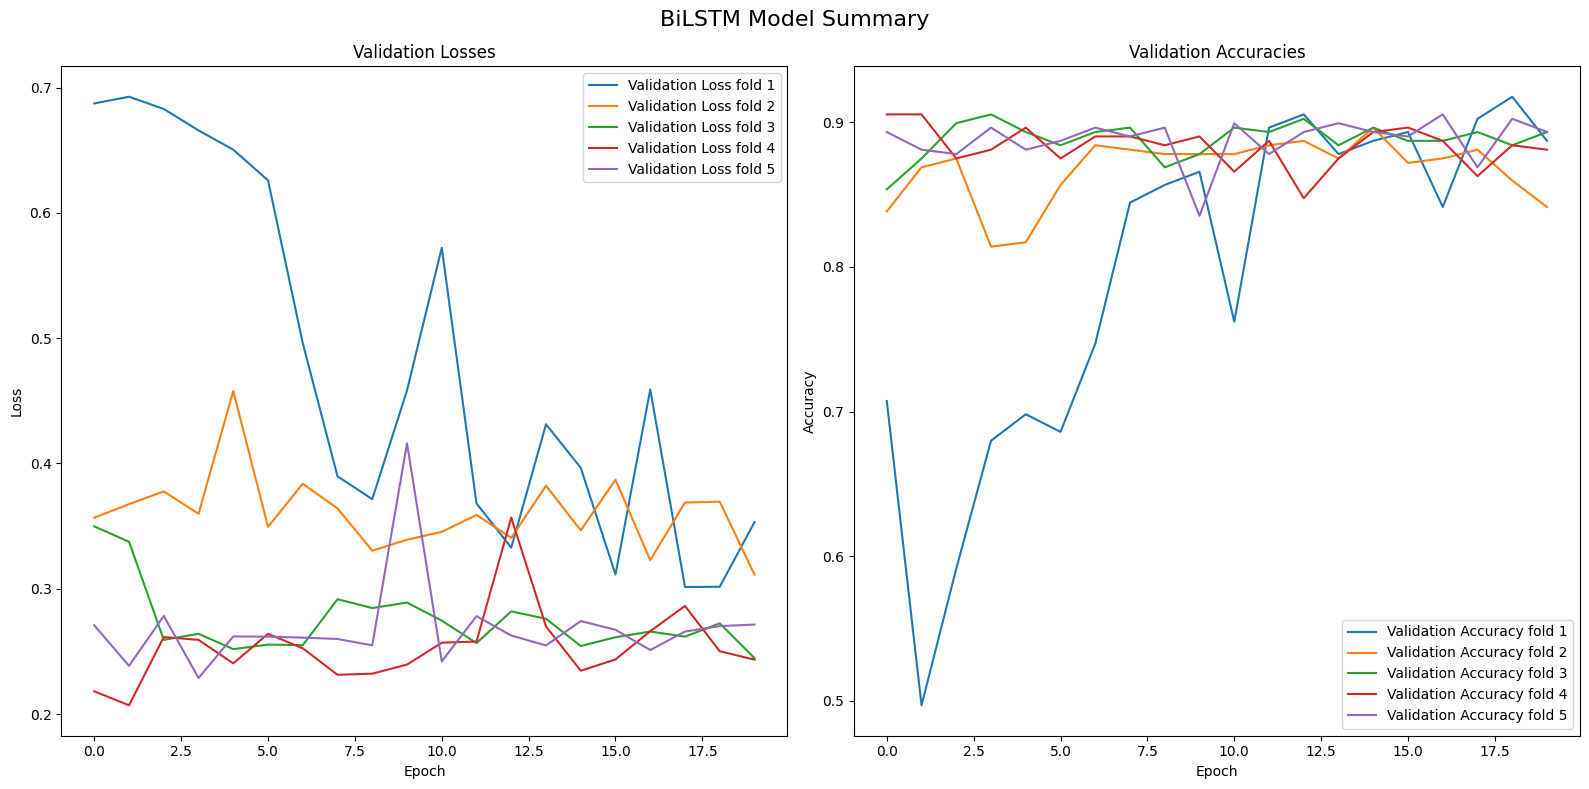


 
 Test Loss: 0.3507, Test accuracy:87.07


In [37]:
my = model_train_cross_validation(model=model_BiLSTM, Name="BiLSTM", n_splits=5, train_dataset=train_dataset, test_dataset=test_dataset, batch_size=128,
                                 optimizer=optimizer_BiLSTM, criterion=criterion_BiLSTM, num_epochs=20, device=device, Print_details=True)

my.train()
my.test()


BiLSTM Advantage in SMILES Dataset Analysis

Bidirectional LSTM (BiLSTM) has a distinct advantage over LSTM in the context of analyzing SMILES datasets. SMILES strings, representing molecular structures, often exhibit intricate relationships between characters, necessitating an understanding of context from both the beginning and the end of the sequence.

BiLSTM's unique capability to process sequences in both the forward and backward directions enables it to capture long-range dependencies and context effectively. This is particularly crucial for discerning the complex relationships within molecular representations.

While LSTM processes sequences sequentially from one end, BiLSTM provides a more comprehensive view of the sequence by considering information from both ends simultaneously. This holistic approach proves beneficial when dealing with SMILES strings of varying lengths and complex structural patterns.


# Comparison of Models

Initially, the SMILES strings were divided based on their length. However, the reason for not having an equal number of samples in each division was that, for example, in divisions 8, 9, and 10 where the strings were longer, there was only one sample, while in divisions 1 and 2, which had shorter strings, there were around 900 samples each. This division was done in such a way that the number of samples in each division is approximately equal, making it better for comparing models trained on them.

In [56]:
df_test['bin'] = pd.qcut(df_test['smiles_length'], q=10, labels=False)

df_test['bin'].value_counts()


4    47
7    44
0    43
3    42
9    41
1    40
2    40
6    38
5    38
8    37
Name: bin, dtype: int64

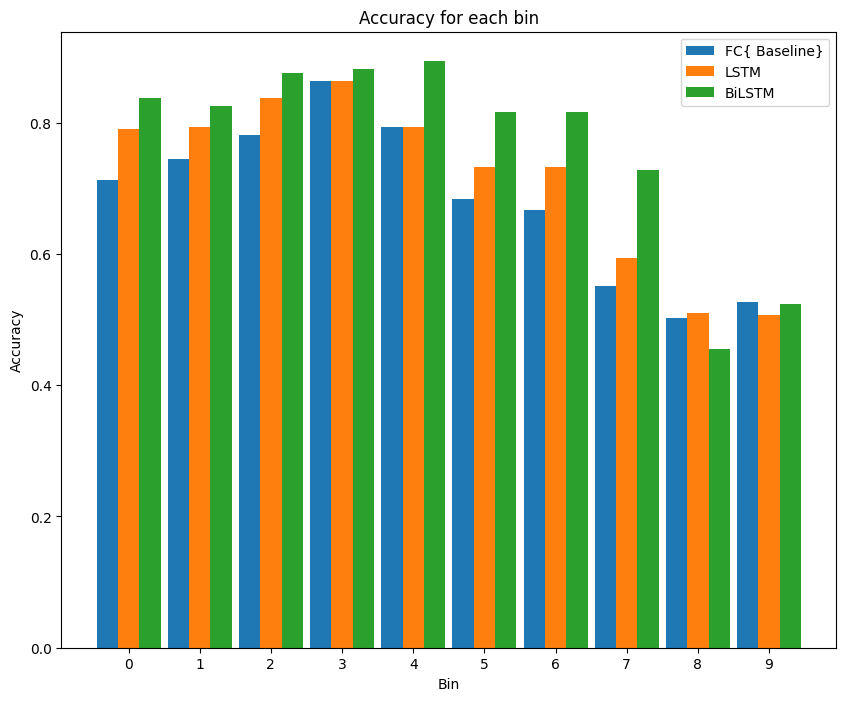

In [69]:
model_fc = FC(input_size=max_length*vocab_size , hidden_size=200).to(device)
model_LSTM = LSTM(input_size=vocab_size , hidden_size=200, num_layers=4).to(device)
model_BiLSTM = BiLSTM(input_size=vocab_size , hidden_size=200, num_layers=4).to(device)

model_fc.load_state_dict(torch.load('best_model_FC.pth'))
model_LSTM.load_state_dict(torch.load('best_model_LSTM.pth'))
model_BiLSTM.load_state_dict(torch.load('best_model_BiLSTM.pth'))

model_fc.eval()
model_LSTM.eval()
model_BiLSTM.eval()


# Accuracies for each bin
accuracies_fc = []
accuracies_lstm = []
accuracies_bilstm = []


models = [(model_fc, accuracies_fc), (model_LSTM, accuracies_lstm), (model_BiLSTM, accuracies_bilstm)]

# Group the test data by the bin column
for bin, group in df_test.groupby('bin'):

    inputs = torch.stack(group['embedded'].tolist()).to(device)
    labels = torch.tensor(group['p_np'].tolist()).to(device)

    for model, accuracies in models:

        with torch.no_grad():
            outputs = model(inputs)

        predictions = outputs.round()
        accuracy = (predictions == labels).float().mean().item()
        accuracies.append(accuracy)

# Create histogram
plt.figure(figsize=(10, 8))

bins = np.arange(len(df_test['bin'].unique()))
width = 0.3
plt.bar(bins - width, accuracies_fc, width, label='FC{ Baseline}')
plt.bar(bins, accuracies_lstm, width, label='LSTM')
plt.bar(bins + width, accuracies_bilstm, width, label='BiLSTM')
plt.xlabel('Bin')
plt.ylabel('Accuracy')
plt.xticks(bins, bins)
plt.legend(loc='upper right')
plt.title('Accuracy for each bin')
plt.show()

# Performance Improvement of LSTM and BiLSTM over FC in SMILES String Data with Increased Sequence Lengths

In the context of SMILES string data, both LSTM (Long Short-Term Memory) and BiLSTM (Bidirectional LSTM) outperform a Fully Connected (FC) network, especially when dealing with longer sequences. The key reasons for this improvement are as follows:

## 1. Capturing Long-Range Dependencies:
   - SMILES strings often represent intricate molecular structures with dependencies between distant characters.
   - LSTM and BiLSTM are designed to capture long-range dependencies, allowing them to understand the complex relationships within molecular representations.

## 2. Bidirectional Context:
  - In the case of lengthy SMILES sequences, considering information from both ends proves crucial for a comprehensive understanding of the overall structure.

## 3. Sequential vs. Holistic Processing:
   - LSTM processes sequences sequentially from one end to the other.
   - BiLSTM, on the other hand, provides a more holistic view by considering information from both ends simultaneously.
   - This proves advantageous when dealing with longer SMILES strings and their complex structural patterns.

## 4. Handling Varied Sequence Lengths:
   - SMILES strings may vary in length, and LSTM and BiLSTM are better equipped to handle such variability.
   - FC networks, which lack the sequential and bidirectional context, may struggle to capture the nuanced dependencies in longer SMILES sequences.

In summary, the superior performance of LSTM and BiLSTM over FC networks in the context of SMILES string data with increased sequence lengths can be attributed to their ability to capture long-range dependencies, consider bidirectional context, process sequences holistically, and handle variations in sequence lengths effectively.
